In [1]:
from src.libs.lib import *
import pandas as pd
import matplotlib.pyplot as plt
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
df_original = pd.read_csv("src/data/usage_statistics_erp.csv")


Hash numérica de 5 dígitos: 94799


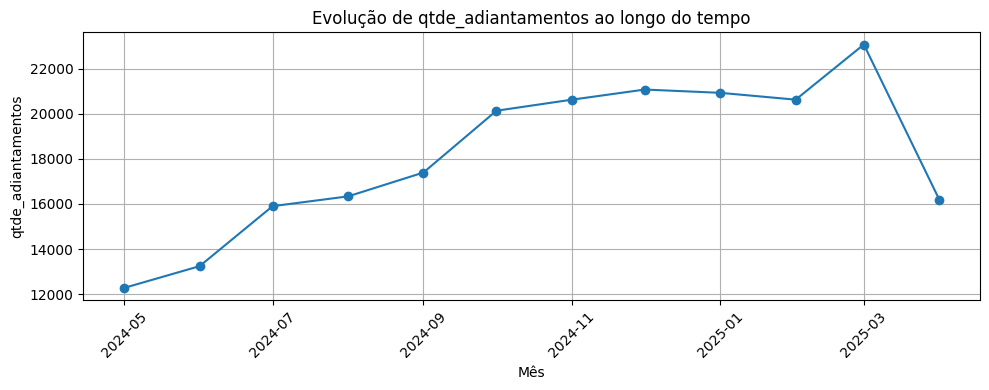

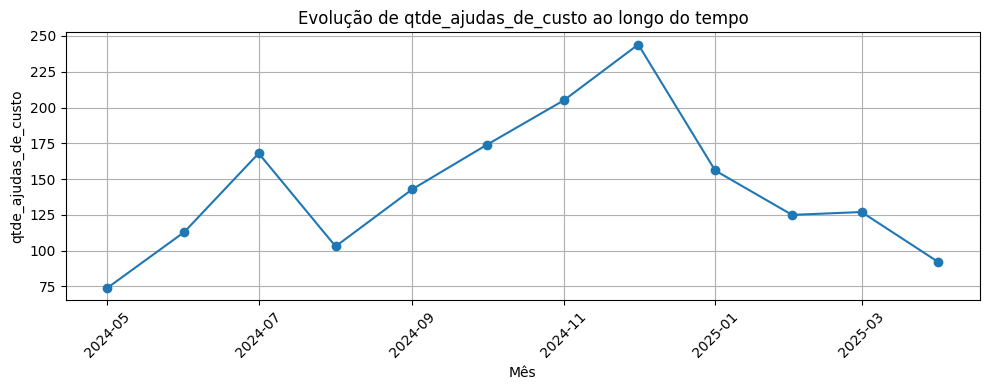

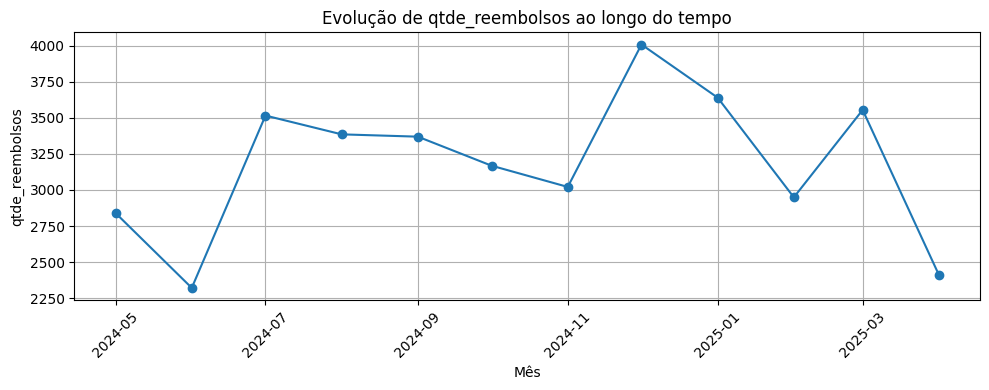

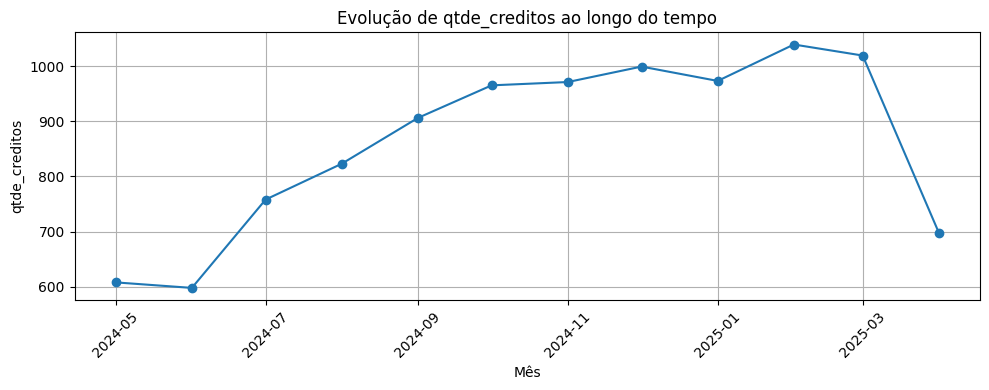

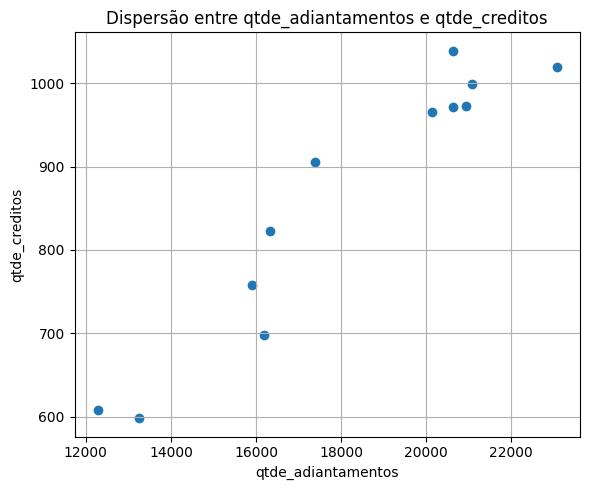

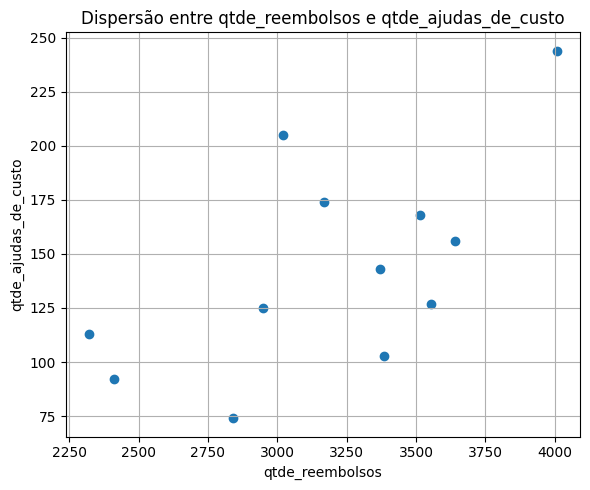

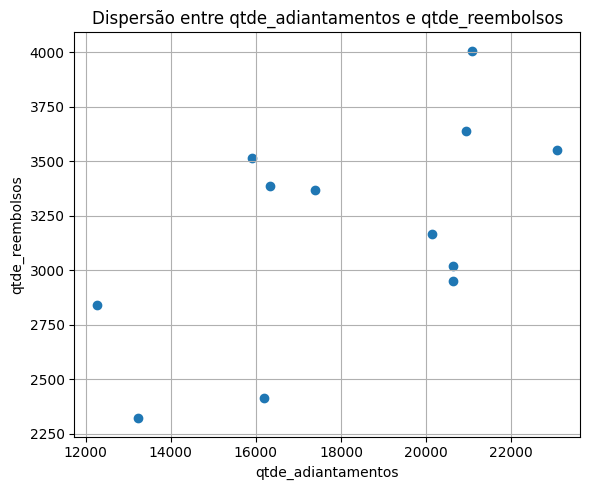

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

# Carregar os dados
df = df_original.copy()
df['mes'] = pd.to_datetime(df['mes'])
df = df.sort_values(by='mes').reset_index(drop=True)

# Variáveis contínuas
variaveis = ['qtde_adiantamentos', 'qtde_ajudas_de_custo', 'qtde_reembolsos', 'qtde_creditos']

# --- Line Plots por variável ---
for var in variaveis:
    plt.figure(figsize=(10, 4))
    plt.plot(df['mes'], df[var], marker='o')
    plt.title(f'Evolução de {var} ao longo do tempo')
    plt.xlabel('Mês')
    plt.ylabel(var)
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# --- Gráficos de Dispersão entre variáveis relevantes ---
pares_dispersao = [
    ('qtde_adiantamentos', 'qtde_creditos'),
    ('qtde_reembolsos', 'qtde_ajudas_de_custo'),
    ('qtde_adiantamentos', 'qtde_reembolsos')
]

for x, y in pares_dispersao:
    plt.figure(figsize=(6, 5))
    plt.scatter(df[x], df[y])
    plt.title(f'Dispersão entre {x} e {y}')
    plt.xlabel(x)
    plt.ylabel(y)
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [4]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Copiar o dataframe original
df_model = df.copy()

# Criar variáveis derivadas
for col in ['qtde_adiantamentos', 'qtde_ajudas_de_custo', 'qtde_reembolsos', 'qtde_creditos']:
    df_model[f'{col}_delta'] = df_model[col].diff()
    df_model[f'{col}_pct_change'] = df_model[col].pct_change()
    df_model[f'{col}_rolling_mean_2'] = df_model[col].rolling(window=2).mean()

# Remover as primeiras linhas com NaN devido às diferenças e médias móveis
df_model = df_model.dropna().reset_index(drop=True)

# Adicionar variável de tempo (mês como número para uso como feature)
df_model['mes_num'] = df_model['mes'].dt.month + 12 * (df_model['mes'].dt.year - df_model['mes'].dt.year.min())

# Separar as features e targets
features = [col for col in df_model.columns if col not in ['mes', 'qtde_adiantamentos', 'qtde_ajudas_de_custo',
                                                            'qtde_reembolsos', 'qtde_creditos', 'total_transacoes_mes']]

# Dicionário para guardar resultados por target
resultados_modelos = {}

# Função para treinar e avaliar modelos
def treinar_modelos(df, target_col):
    X = df[features]
    y = df[target_col]
    
    # Separar treino e teste (últimos 3 meses como teste)
    X_train, X_test = X[:-3], X[-3:]
    y_train, y_test = y[:-3], y[-3:]

    modelos = {
        'LinearRegression': LinearRegression(),
        'RandomForest': RandomForestRegressor(random_state=42),
        'XGBoost': XGBRegressor(random_state=42, verbosity=0)
    }

    metricas = []

    for nome, modelo in modelos.items():
        modelo.fit(X_train, y_train)
        y_pred = modelo.predict(X_test)
        metricas.append({
            'modelo': nome,
            'RMSE': np.sqrt(mean_squared_error(y_test, y_pred)),
            'MAE': mean_absolute_error(y_test, y_pred),
            'R2': r2_score(y_test, y_pred)
        })

    return pd.DataFrame(metricas)

# Treinar e avaliar modelos para cada variável-alvo
for alvo in ['qtde_adiantamentos', 'qtde_ajudas_de_custo', 'qtde_reembolsos', 'qtde_creditos']:
    resultados_modelos[alvo] = treinar_modelos(df_model, alvo)

# Combinar os resultados em um único dataframe para exibição
tabela_resultados = pd.concat(resultados_modelos, names=['Variável Alvo', 'Linha']).reset_index(level=1, drop=True).reset_index()



In [5]:
display(tabela_resultados)

,Variável Alvo,modelo,RMSE,MAE,R2
0,qtde_adiantamentos,LinearRegression,0.741158,0.642374,1.000000
1,qtde_adiantamentos,RandomForest,2638.547564,2311.900000,0.141323
2,qtde_adiantamentos,XGBoost,3006.273940,2394.332764,-0.114697
3,qtde_ajudas_de_custo,LinearRegression,94.704363,82.485291,-33.823230
4,qtde_ajudas_de_custo,RandomForest,52.514766,51.490000,-9.707595
5,qtde_ajudas_de_custo,XGBoost,35.014560,33.172226,-3.760213
6,qtde_reembolsos,LinearRegression,1.403691,1.228609,0.999991
7,qtde_reembolsos,RandomForest,528.714669,444.076667,-0.286748
8,qtde_reembolsos,XGBoost,776.310062,620.816101,-1.774095
9,qtde_creditos,LinearRegression,0.446859,0.371870,0.999992
